In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### set default figsize
plt.rcParams['figure.figsize'] = (14,6)

In [139]:
mobile_sales = pd.read_excel('mobilesales.xlsx', engine='openpyxl')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [140]:
mobile_sales.set_index('DATE', inplace=True)
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


In [141]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

<Axes: xlabel='DATE'>

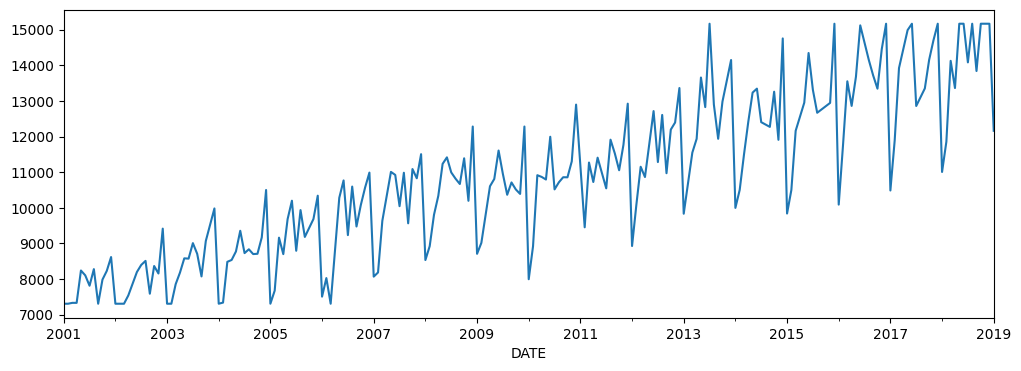

In [142]:
mobile_sales.Sales.clip(lower=mobile_sales.Sales.quantile(0.05), upper=mobile_sales.Sales.quantile(0.95)).plot(figsize=(12,4))

In [143]:
train_max_date = mobile_sales.index[-12]
train_max_date

Timestamp('2018-02-01 00:00:00')

In [144]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

**ADF Test**

In [145]:
import statsmodels.api as sm

sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

np.float64(0.9451861677902987)

In [146]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   print(pvalue)
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(mobile_sales.Sales)

0.9451861677902987
Sequence is not stationary


<Axes: xlabel='DATE'>

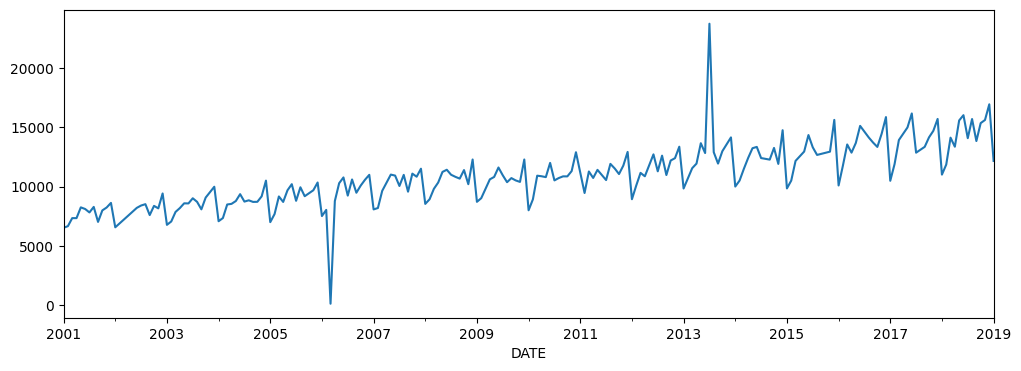

In [147]:
mobile_sales.Sales.plot(figsize=(12,4))

## Making Series Stationary 

In [148]:
import seaborn as sns
import yfinance as yf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [149]:
# Download Apple stock data with correct ticker and date range
apple_stock_data = yf.download('AAPL', start='2020-01-01', end='2024-12-31')
apple_stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538528,72.598907,71.292319,71.545905,135480400
2020-01-03,71.833298,72.594063,71.608692,71.765674,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200


**Differencing**

In [150]:
adf_test(apple_stock_data.Close)

detrend = apple_stock_data.Close.diff(1)
detrend

0.8565024228577311
Sequence is not stationary


Ticker,AAPL
Date,
2020-01-02,NaN
2020-01-03,-0.705231
2020-01-06,0.572372
2020-01-07,-0.340515
2020-01-08,1.159264
...,...
2024-12-23,0.777237
2024-12-24,2.919662
2024-12-26,0.817047


<Axes: xlabel='Date'>

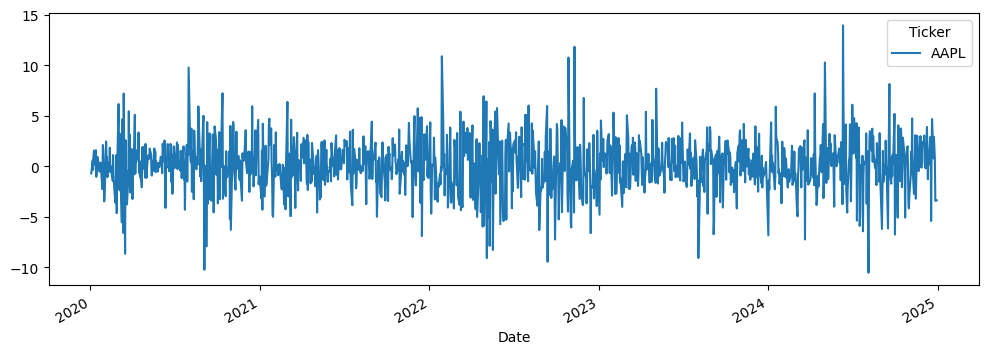

In [151]:
detrend.dropna().plot(figsize=(12,4))

In [152]:
adf_test(detrend.dropna())

0.0
Sequence is stationary


**Removing seasonality via differencing**

mobiles_sales.Sales.diff(Seasonal Window)

3.5290619669992056e-10
Sequence is stationary


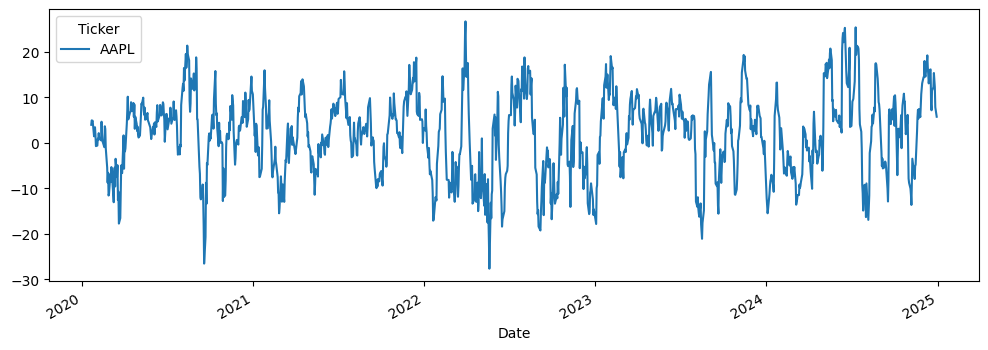

In [153]:
deseason = apple_stock_data.Close.diff(12)
deseason.dropna().plot(figsize=(12,4))
adf_test(deseason.dropna())

**Removing both Trend and Seasonality**

2.18195706269194e-07
Sequence is stationary


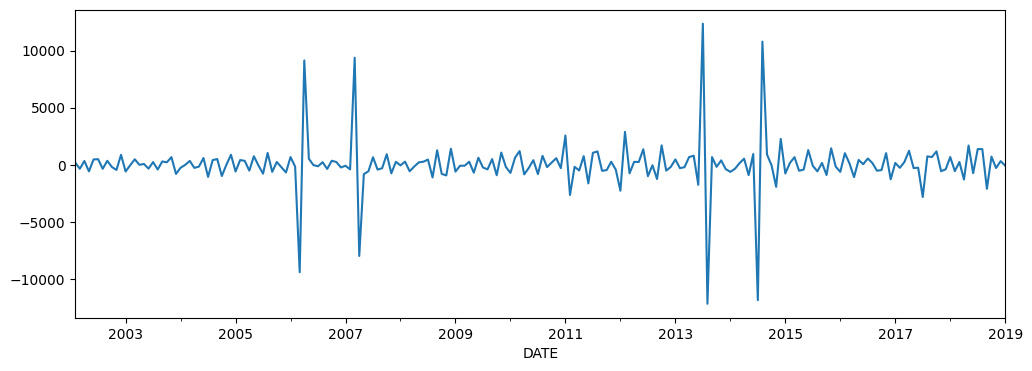

In [154]:
stationary = mobile_sales.Sales.diff(1).diff(12)
stationary.dropna().plot(figsize=(12,4))
adf_test(stationary.dropna())

**Log Transformation**

Log transformation can help stabilize variance and reduce the effect of exponential growth trends.

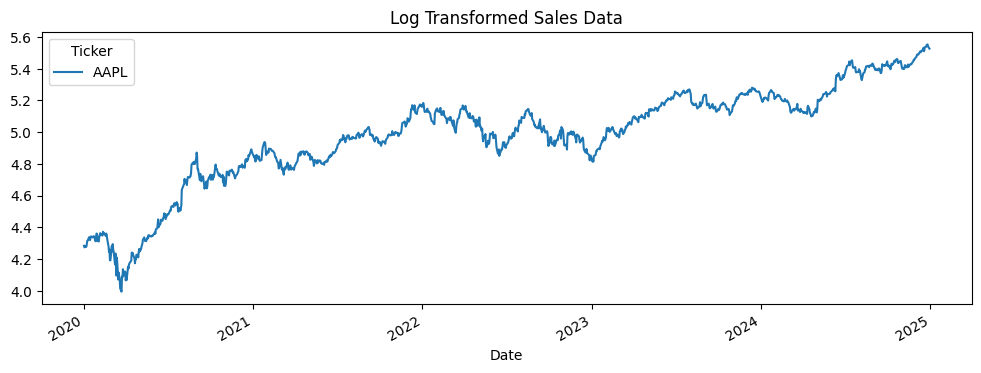

0.5663046702931108
Sequence is not stationary


In [155]:
# Apply log transformation to the sales data
log_sales = np.log(apple_stock_data.Close)
log_sales.plot(figsize=(12,4), title='Log Transformed Sales Data')
plt.show()

adf_test(log_sales)

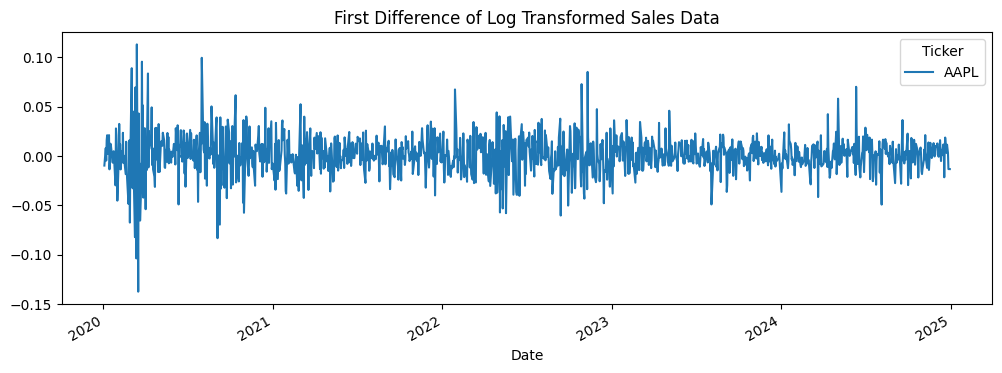

1.446290067036561e-20
Sequence is stationary


In [156]:


# Apply differencing to log transformed data
log_diff = log_sales.diff(1)
log_diff.dropna().plot(figsize=(12,4), title='First Difference of Log Transformed Sales Data')
plt.show()

adf_test(log_diff.dropna())

**Double Log Transformation**

Double log transformation (log of log) can be useful for data with very high variance or extreme values.

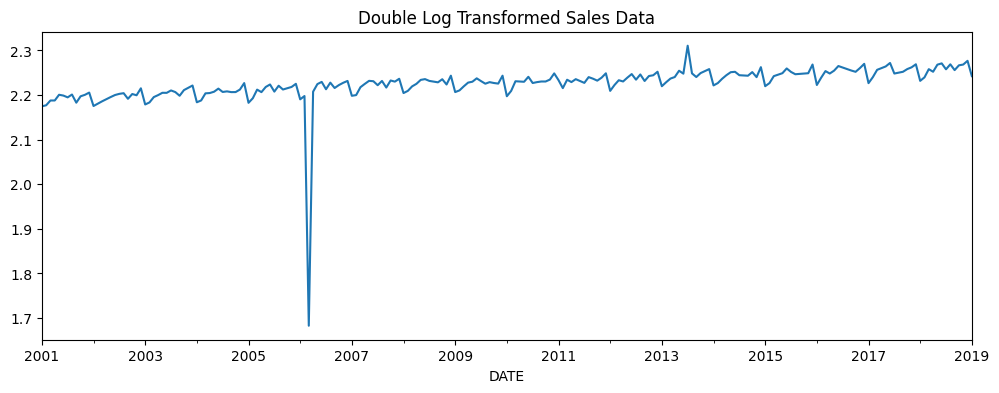

0.009632940993319447
Sequence is stationary


In [157]:
# Apply double log transformation (log of log)
# First ensure all values are positive for log transformation
positive_sales = mobile_sales.Sales + abs(mobile_sales.Sales.min()) + 1  # Make all values positive
double_log_sales = np.log(np.log(positive_sales))

double_log_sales.plot(figsize=(12,4), title='Double Log Transformed Sales Data')
plt.show()

adf_test(double_log_sales)

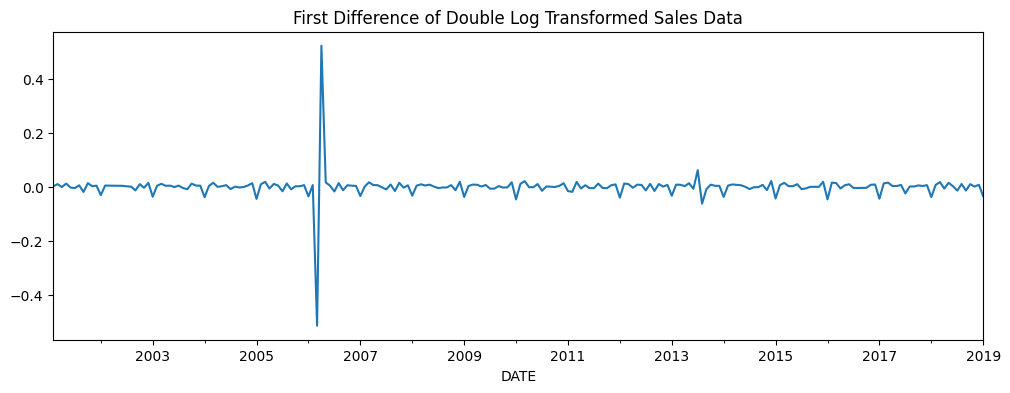

1.7836400918112277e-12
Sequence is stationary


In [158]:
# Apply differencing to double log transformed data
double_log_diff = double_log_sales.diff(1)
double_log_diff.dropna().plot(figsize=(12,4), title='First Difference of Double Log Transformed Sales Data')
plt.show()
adf_test(double_log_diff.dropna())

**There are also other transformations**
- sqrt transformation
- Box-Cox transformation (log + sqrt)

In [159]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)


### Creating function to measure and print all three metric
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

## ACF and PACF

In [160]:
lag = 1
mobile_sales.Sales.shift(lag).head()

DATE
2001-01-01       NaN
2001-02-01    6519.0
2001-03-01    6654.0
2001-04-01    7332.0
2001-05-01    7332.0
Name: Sales, dtype: float64

In [161]:
lag = 12
np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag)[lag:])[0][1]

np.float64(0.787032210524913)

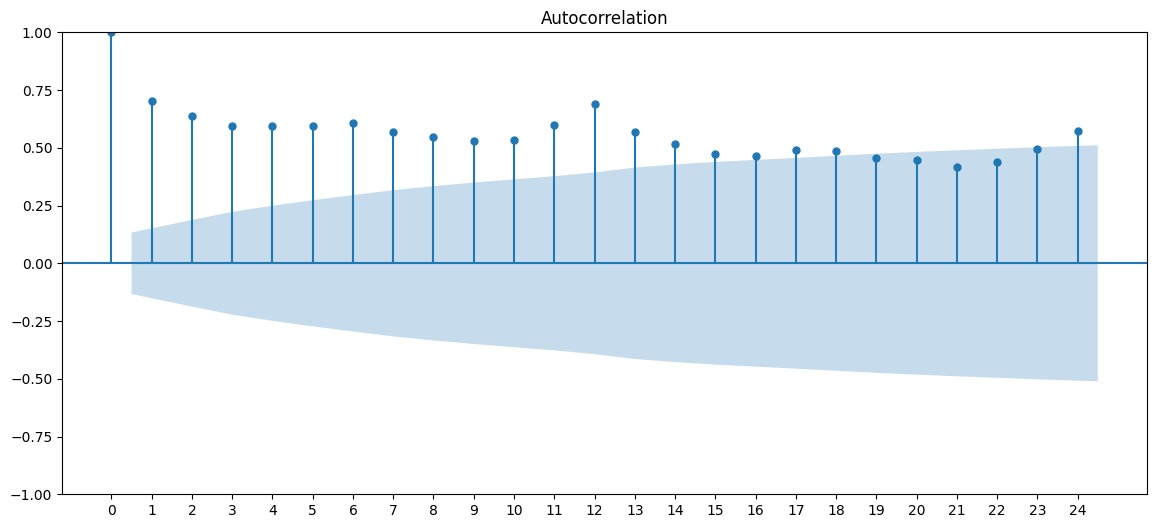

In [162]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(mobile_sales.Sales);
plt.xticks(range(25))
plt.show()

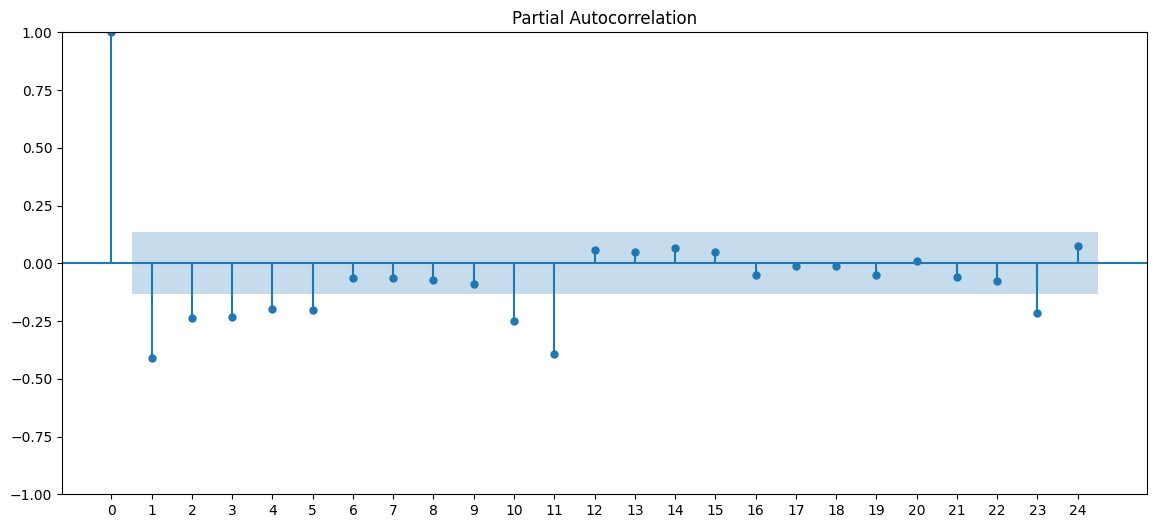

In [163]:
### Only Seasonality and residuals
plot_pacf(mobile_sales.Sales.diff().dropna())
plt.xticks(range(25))
plt.show()

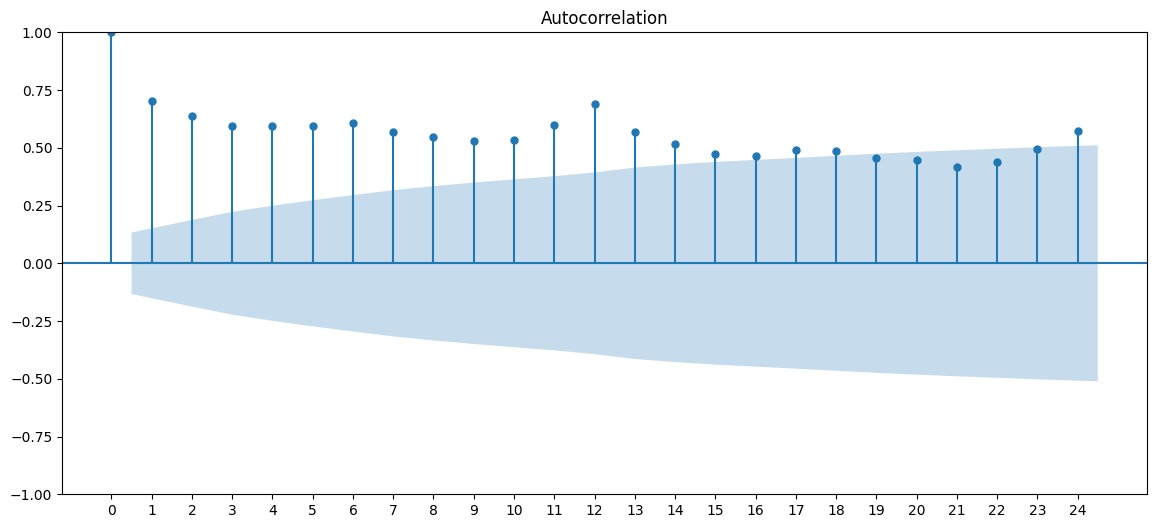

In [164]:
plot_acf(mobile_sales.Sales);
plt.xticks(range(25))
plt.show()

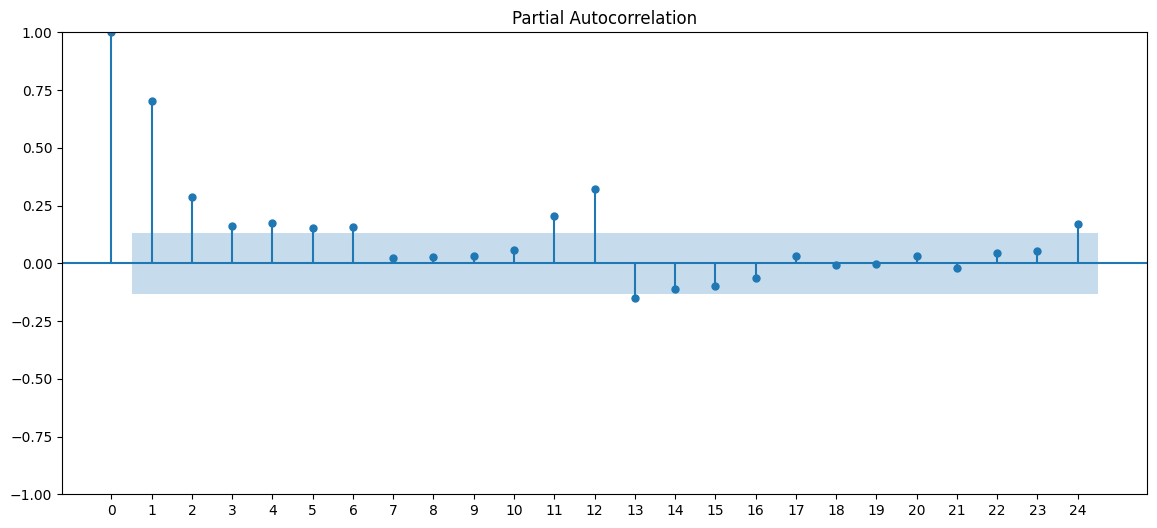

In [165]:
plot_pacf(mobile_sales.Sales);
plt.xticks(range(25))
plt.show()